# Más Modelos de clasificación para localidades urbanas y rurales. 

Este trabajo es la continuación  de otros dos elaborados previamente en el que se toma una versión módificada de una base de datos del INEGI y (1) se intenta predecir [la población de una localidad con base a las condiciones de vivienda](https://ethan-r-r.github.io/Modelo-Poblacion-por-condiciones-de-vivienda/) y también (2) se intentó clasificar si una [localidad era urbana o rural con base a las mismas condiciones de vivienda](https://ethan-r-r.github.io/Clasificacion_Urbano_Rural_Por_Condiciones_de_Vivienda/)


Se siguen con los esfuerzos de clasificar si una localidad es urbana o rural, con base a las proporciones de viviendas que tienen una característica en particular, sin embargo ahora se añadirán modelos aplicando Linear Discriminant Analyisis y árboles de decisión.


El procesado de la base de datos, manejo de valores atípicos y eliminación de huecos se puede ver en el primer proyecto (1) y aquí se va a reciclar el código; omitiendo los detalles para evitar redundancias, pues no es el enfoque de este reporte.

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 

df = pd.read_csv("conjunto_de_datos_iter_19CSV20.csv")

#https://sparkbyexamples.com/pandas/pandas-delete-rows-based-on-column-value/#:~:text=To%20delete%20rows%20based%20on%20specific%20column%20values%20in%20a,method%20to%20remove%20those%20rows.
df = df.drop(df[df["LATITUD"].isnull()].index)

#variables cualitativas o redundantes se dejaron en la base de datos por si se quiere revisar individualmente algo de las caracteristicas de la zona
df = df.drop(columns = ['ENTIDAD','NOM_ENT','MUN','LOC','NOM_MUN','LONGITUD','LATITUD','ALTITUD'])
#Trabajaremos solo con las viviendas particulares. 
df = df.drop(columns = ['VIVTOT','TVIVHAB','TVIVPAR','OCUPVIVPAR','TVIVPARHAB'])
df.drop('NOM_LOC',inplace = True,axis=1)

print("Tamaño original ", df.shape)
#la siguiente linea se genero con ayuda de chatgpt
#añade una columna que incluye la cantidad de huecos que tiene cada fila
df["DatosVacios"] = df.isnull().sum(axis=1)
print(df.DatosVacios)



df.drop(df[df["DatosVacios"]>=(30)].index, inplace=True)
print("Observaciones eliminando las que tienen menos de la mitad de los datos", df.shape)
#Nos quedan solo 2135 observaciones que cumplen el criterio
df.drop(df[df["DatosVacios"]>(0)].index, inplace=True)
print("Observaciones eliminando las que no tienen todos los datos ", df.shape)
print(df.columns)




Tamaño original  (4821, 54)
4        0
5       53
6       53
7       53
8       53
        ..
4966    53
4967    53
4968    53
4969    53
4970    53
Name: DatosVacios, Length: 4821, dtype: int64
Observaciones eliminando las que tienen menos de la mitad de los datos (1990, 55)
Observaciones eliminando las que no tienen todos los datos  (1990, 55)
Index(['POBTOT', 'TOTHOG', 'HOGJEF_F', 'HOGJEF_M', 'POBHOG', 'PHOGJEF_F',
       'PHOGJEF_M', 'VIVPARH_CV', 'VIVPAR_DES', 'VIVPAR_UT', 'PROM_OCUP',
       'PRO_OCUP_C', 'VPH_PISODT', 'VPH_PISOTI', 'VPH_1DOR', 'VPH_2YMASD',
       'VPH_1CUART', 'VPH_2CUART', 'VPH_3YMASC', 'VPH_C_ELEC', 'VPH_S_ELEC',
       'VPH_AGUADV', 'VPH_AEASP', 'VPH_AGUAFV', 'VPH_TINACO', 'VPH_CISTER',
       'VPH_EXCSA', 'VPH_LETR', 'VPH_DRENAJ', 'VPH_NODREN', 'VPH_C_SERV',
       'VPH_NDEAED', 'VPH_DSADMA', 'VPH_NDACMM', 'VPH_SNBIEN', 'VPH_REFRI',
       'VPH_LAVAD', 'VPH_HMICRO', 'VPH_AUTOM', 'VPH_MOTO', 'VPH_BICI',
       'VPH_RADIO', 'VPH_TV', 'VPH_PC', 'VPH_TELEF', 'V

Igual que en los últimos dos proyectos, en lugar de manejar como variables de entrada el número de viviendas con una característica particular se van a manejar las proporciones de vivienda que cuentan con una característica particular.



In [3]:
#Esta linea de codigo fue hecha con ayuda de CHATGPT
excluirDiv = ['PROM_OCUP','PROM_OCUP_C','VIVPARH_CV','POBTOT','NOM_LOC']
df.loc[:,~df.columns.isin(excluirDiv) ] = df.loc[:,~df.columns.isin(excluirDiv)].div(df['VIVPARH_CV'],axis=0)
print(df.head())
df.drop('VIVPARH_CV',inplace = True,axis=1)


    POBTOT    TOTHOG  HOGJEF_F  HOGJEF_M    POBHOG  PHOGJEF_F  PHOGJEF_M  \
4     1992  1.000000  0.301471  0.698529  3.661765   1.029412   2.632353   
13      15  1.000000  0.000000  1.000000  5.000000   0.000000   5.000000   
16      53  1.000000  0.214286  0.785714  3.785714   0.857143   2.928571   
17     870  1.013216  0.259912  0.753304  3.832599   0.955947   2.876652   
21    2080  1.001325  0.242384  0.758940  2.747020   0.545695   2.201325   

    VIVPARH_CV  VIVPAR_DES  VIVPAR_UT  ...   VPH_CEL  VPH_INTER  VPH_STVP  \
4        544.0    0.306985   0.154412  ...  0.920956   0.476103  0.474265   
13         3.0    1.666667   0.000000  ...  1.000000   0.000000  0.333333   
16        14.0    0.928571   0.285714  ...  1.000000   0.285714  0.285714   
17       227.0    0.264317   0.215859  ...  0.960352   0.370044  0.409692   
21       755.0    0.605298   0.437086  ...  0.876821   0.500662  0.617219   

    VPH_SPMVPI   VPH_CVJ  VPH_SINRTV  VPH_SINLTC  VPH_SINCINT  VPH_SINTIC  \
4  

En el proyecto (2) se transformó la variable de salida que anteriormente era el logaritmo base 10 de la población a una variable binaria que indicaba si la localidad pasaba de una población de 2500 personas. El mismo concepto aplica, y se usará el mismo código para binarizar la variable. 


In [4]:
#Crear data frame localidades que se pueden considerar ciudad
Rural = df.POBTOT <=2500
Urbano =pd.DataFrame({"Urbano":1-Rural})

#concatenar al dataframe original
df = pd.concat([df,Urbano],axis=1)

df.drop('POBTOT',inplace = True,axis=1)
df.drop('DatosVacios',inplace = True,axis=1)
print(df.Urbano.value_counts())
print(df.head())


Urbano
0    1901
1      89
Name: count, dtype: int64
      TOTHOG  HOGJEF_F  HOGJEF_M    POBHOG  PHOGJEF_F  PHOGJEF_M  VIVPAR_DES  \
4   1.000000  0.301471  0.698529  3.661765   1.029412   2.632353    0.306985   
13  1.000000  0.000000  1.000000  5.000000   0.000000   5.000000    1.666667   
16  1.000000  0.214286  0.785714  3.785714   0.857143   2.928571    0.928571   
17  1.013216  0.259912  0.753304  3.832599   0.955947   2.876652    0.264317   
21  1.001325  0.242384  0.758940  2.747020   0.545695   2.201325    0.605298   

    VIVPAR_UT  PROM_OCUP  PRO_OCUP_C  ...   VPH_CEL  VPH_INTER  VPH_STVP  \
4    0.154412       3.66    0.001654  ...  0.920956   0.476103  0.474265   
13   0.000000       5.00    0.556667  ...  1.000000   0.000000  0.333333   
16   0.285714       3.79    0.097143  ...  1.000000   0.285714  0.285714   
17   0.215859       3.78    0.004714  ...  0.960352   0.370044  0.409692   
21   0.437086       2.74    0.000887  ...  0.876821   0.500662  0.617219   

    VPH_S

Lamentablemente hay un gran desbalance de datos, que ya había causado problemas en proyectos anteriores. Sin embargo, se intentará seguir trabajando con otros modelos viendo para ver si funcionan mejor. 

Ahora se procederá a separar los datos entre entrenamiento y prueba.


In [5]:
#importar función para separar entre entrenamiento y prueba
from sklearn.model_selection import train_test_split

# Dividir datos
Y = df.Urbano
X = df.drop("Urbano",axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, random_state=919, stratify=Y)
# Imprimir conteo en entrenamiento
print(Y.value_counts())
print(Y_train.value_counts())

# Imprimir conteo en prueba
print(Y_test.value_counts())
print(X_train.shape)


Urbano
0    1901
1      89
Name: count, dtype: int64
Urbano
0    1521
1      71
Name: count, dtype: int64
Urbano
0    380
1     18
Name: count, dtype: int64
(1592, 52)



Solo para visualizar cómo sería un modelo de regresión logística se va a utilizar la función GLM de statsmodels, a la que se le añade la familia de Binomial que está ligada a la función Logit. 


In [6]:
from statsmodels.genmod.generalized_linear_model import GLM
import statsmodels.api as sm
#línea generada con apoyo de ChatGPT
model = GLM(Y_train,sm.add_constant(X_train), family= sm.families.Binomial())
results = model.fit()

print(results.summary())

c:\Users\ethan\anaconda3\Lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


                 Generalized Linear Model Regression Results                  
Dep. Variable:                 Urbano   No. Observations:                 1592
Model:                            GLM   Df Residuals:                     1541
Model Family:                Binomial   Df Model:                           50
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Thu, 20 Mar 2025   Deviance:                       2947.3
Time:                        10:26:37   Pearson chi2:                 1.44e+17
No. Iterations:                    51   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        6.058e+16   6.65e+08   9.11e+07      

c:\Users\ethan\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:1056: RuntimeWarning: divide by zero encountered in log
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu + 1e-20)) +
c:\Users\ethan\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:1056: RuntimeWarning: invalid value encountered in multiply
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu + 1e-20)) +


En un trabajo anterior (2) se había hecho un proceso de selección de características para reducirlas a solo 5. Ahora se considera apropiado hacer otra selección de características con el modelo de GLM para solo considerar dos variables para el árbol de decisiones y el LDA. 
Para la selección de características se hará un proceso de selección hacia adelante con validación cruzada de 5 folds en el que la métrica es los resultados del f1.



In [7]:
from sklearn.linear_model import LogisticRegression
from mlxtend.feature_selection import SequentialFeatureSelector
model2 = LogisticRegression(class_weight="balanced")
subX = SequentialFeatureSelector(model2, k_features=(2,2),forward = True, scoring = "f1", cv = 5).fit(X_train,Y_train)
print("Variables seleccionadas", subX.k_feature_names_)
NewIndx = list(subX.k_feature_idx_)
XNew = X_train.iloc[:,NewIndx[:]]
#Para fácilitar el proceso, corrí una sola vez el proceso de selección de características y guarde las variables acá. Así podría correr el código varias veces sin esperar 40 segundos extra 
X_test = X_test.iloc[:,NewIndx[:]]

Variables seleccionadas ('VIVPAR_UT', 'VPH_SPMVPI')


Las variables seleccionadas son las que corresponden a la proporción de viviendas particulares de uso temporal y la proporción de viviendas particulares habitadas que tienen servicio de películas, música o videos de paga por Internet respectivamente. 

Ahora se va a utilizar una metodología de Linear Discriminant Analysis para hacer predicciones de clasificación. 

Primero se va a estandarizar la base de datos.

In [8]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.inspection import DecisionBoundaryDisplay
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import numpy as np

%matplotlib inline

#Estandariszar datos 
XNewArbol = XNew
X_testArbol = X_test

XNew["VIVPAR_UT_Scaled"] = StandardScaler().fit_transform(XNew[["VIVPAR_UT"]])
XNew["VPH_SPMVPI_Scaled"] = StandardScaler().fit_transform(XNew[["VPH_SPMVPI"]])
XNew.drop("VIVPAR_UT",inplace = True, axis=1)
XNew.drop("VPH_SPMVPI",inplace = True, axis=1)
X_test["VIVPAR_UT_Scaled"] = StandardScaler().fit_transform(X_test[["VIVPAR_UT"]])
X_test["VPH_SPMVPI_Scaled"] = StandardScaler().fit_transform(X_test[["VPH_SPMVPI"]])

X_test.drop("VIVPAR_UT",inplace = True, axis=1)
X_test.drop("VPH_SPMVPI",inplace = True, axis=1)


print(XNew.head())

print(X_test.head())




      VIVPAR_UT_Scaled  VPH_SPMVPI_Scaled
4818          0.556171          -0.382252
765          -0.324357          -0.014552
1610          0.176488          -0.149625
1418         -0.343868          -0.382252
759           0.116695          -0.382252
      VIVPAR_UT_Scaled  VPH_SPMVPI_Scaled
4775          0.482624          -0.023761
3011         -0.415501           0.881830
1831         -0.291218          -0.356698
4864          9.077306           2.223569
2961         -0.411785           0.938834


C:\Users\ethan\AppData\Local\Temp\ipykernel_25404\3105617161.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  XNew["VIVPAR_UT_Scaled"] = StandardScaler().fit_transform(XNew[["VIVPAR_UT"]])
C:\Users\ethan\AppData\Local\Temp\ipykernel_25404\3105617161.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  XNew["VPH_SPMVPI_Scaled"] = StandardScaler().fit_transform(XNew[["VPH_SPMVPI"]])
C:\Users\ethan\AppData\Local\Temp\ipykernel_25404\3105617161.py:16: SettingWithCopyWarning: 
A value is trying to be set on 

Una vez estandarizada, se va a generar el modelo, y para visualizar los resultados se va a hacer un gráfico variable 1 v.s. variable 2 donde se pueda observar la línea del límite de decisión y por color a que categoría realmente pertenece cada punto. 

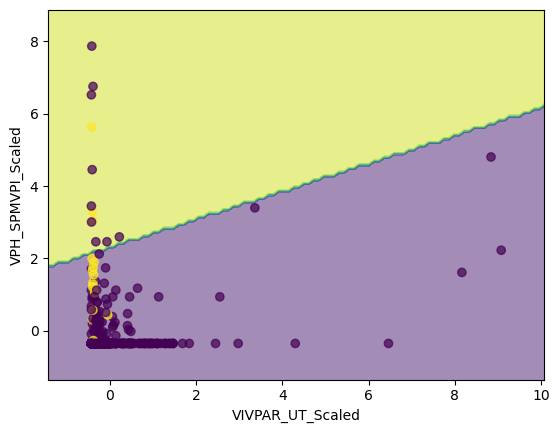

In [9]:

#entrenar modelo
ldamodel = LDA().fit(X_test,Y_test)

disp = DecisionBoundaryDisplay.from_estimator(ldamodel, X_test,alpha = 0.5 ,response_method='predict')

plt.scatter(X_test.VIVPAR_UT_Scaled, X_test.VPH_SPMVPI_Scaled, c=Y_test, alpha = 0.7)

plt.show()





Desde la gráfica se pueden observar varias características desalentadoras del modelo, como lo es el desbalance de datos, y que existe muchas similitudes en las características de ambos tipos de clases. 

Para observar si estás características realmente pudieran afectar al modelo, se va a revisar la matriz de confusión y métricas como el accuracy y el f1, finalmente se verá la curva ROC con los datos de prueba. 


In [10]:
#Importar funciones
from sklearn.metrics import confusion_matrix, classification_report
yhat = ldamodel.predict(X_test)

# Generar la matriz de confusión
cm = confusion_matrix(Y_test,yhat)
# Imprimir la matriz de confusión
print(cm)
# Generar el reporte de clasificación
rep = classification_report(Y_test,yhat)
# Imprimir el reporte de clasificación
print(rep)

[[371   9]
 [ 15   3]]
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       380
           1       0.25      0.17      0.20        18

    accuracy                           0.94       398
   macro avg       0.61      0.57      0.58       398
weighted avg       0.93      0.94      0.93       398




Este modelo no tiene un muy buen desempeño, en especial para detectar a las localidades urbanas. Tiene un valor de F1 de 0.18 y una precisión de 0.20. 

En la matriz de confusión las filas son los valores reales y las columnas son los valores predichos. Se puede observar que hay casi la misma cantidad de predicciones verdaderas como predicciones falsas. Finalmente se hará una curva ROC para observar cómo se comporta el modelo. 


AUC =  0.9486842105263159


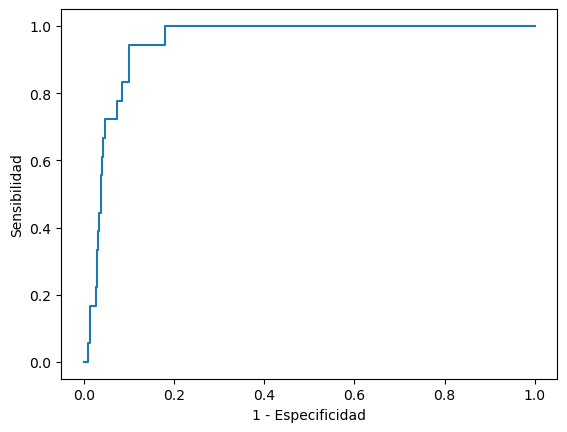

In [11]:
from sklearn.metrics import roc_curve, auc
p1 = ldamodel.predict_proba(X_test)
#CALCULAR fpr, tpr y thresholds
fpr, tpr, thresholds = roc_curve(Y_test,p1[:,1],pos_label=1)
roc_auc = auc(fpr,tpr)
# Imprimir AUC
print("AUC = ",roc_auc)

# Graficar
plt.plot(fpr,tpr)
plt.xlabel("1 - Especificidad")
plt.ylabel("Sensibilidad")
plt.show()


La curva ROC indica y el valor de la AUC indican una buena calidad de modelo. Posiblemente si se cambiará el umbral se encontrarían mejores resultados. Pero por el momento se va a dejar así. 

Ahora se procederá a hacer un árbol de decisiones con las mismas dos variables. 

Empezaremos entrenando un modelo de árbol y mostrándolo completo.


In [12]:
from sklearn.tree import DecisionTreeClassifier as DTC

tree = DTC().fit(XNewArbol,Y_train)
from sklearn.tree import plot_tree

plt.figure(figsize = (150,100))
plot_tree(tree,filled=True, feature_names= XNewArbol.columns);
plt.show()


Ahora se procederá a podar el árbol utilizando una técnica de validación cruzada. Se usará la técnica de StratifiedKFolds, porque el utilizar otras estrategias como LOOCV sería demasiado tardado.  


Mejor valor de alfa:  0.0049959839357429725


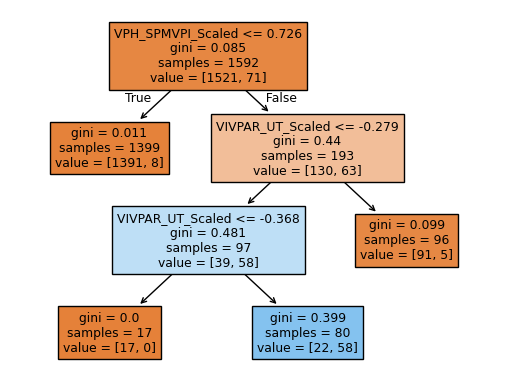

In [13]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Generar objeto de validación cruzada
skf = StratifiedKFold(n_splits = 4)
# Generar secuencia de valores
ccp = np.linspace(0.001, 0.2, 250)
# Inicializar variable de salida
cv_scores = []
# Ciclo donde se calcula el f1-score mediante validación cruzada
for alpha in ccp:
    pruned_tree = DTC(ccp_alpha = alpha)
    cv_scores.append(np.mean(cross_val_score(pruned_tree,X_train,Y_train,cv=skf,scoring= 'f1')))

alpha = ccp[np.argmax(cv_scores)]

print("Mejor valor de alfa: ",alpha)

pruned_tree = DTC(ccp_alpha= alpha).fit(XNewArbol,Y_train)
plt.figure()
plot_tree(pruned_tree,filled = True, feature_names=XNewArbol.columns);
plt.show()


Se bajó significativamente la cantidad de hojas del árbol. Ahora se observará una gráfica similar a la que se usó para visualizar el LDA con los ejes variable 1 v.s. variable 2. 

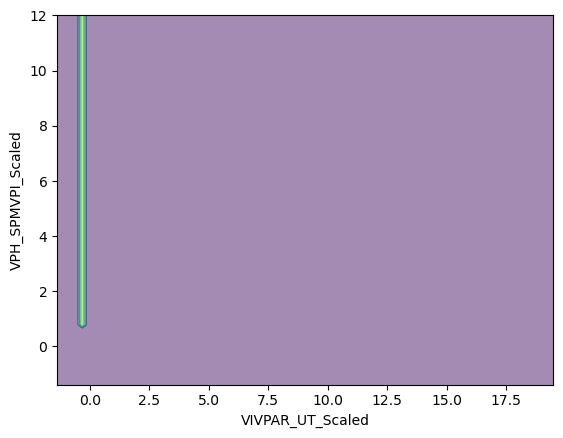

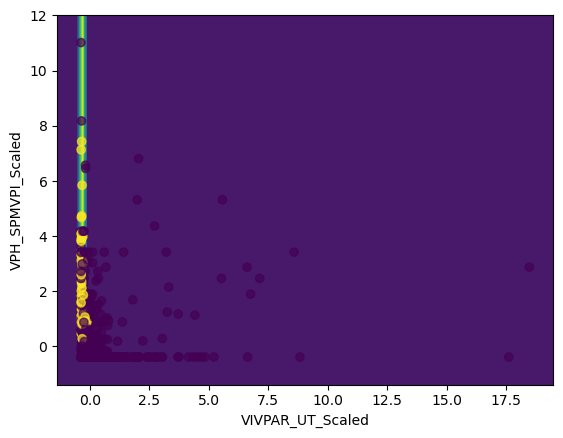

In [14]:
disp2  = DecisionBoundaryDisplay.from_estimator(pruned_tree,XNewArbol,alpha = 0.5)
disp2.plot()
plt.scatter(XNewArbol.VIVPAR_UT_Scaled, XNewArbol.VPH_SPMVPI_Scaled, c=Y_train, alpha = 0.7)
plt.show()

In [ ]:
yhat2 = pruned_tree.predict(X_test)
from sklearn.metrics import f1_score 

# Generar la matriz de confusión
cm2 = confusion_matrix(Y_test,yhat2)
# Imprimir la matriz de confusión
print("Matriz de confusión LDA")
print(cm)
print("Matriz de confusión árbol")
print(cm2)
# Generar el reporte de clasificación
rep2= classification_report(Y_test,yhat2)
# Imprimir el reporte de clasificación
print("Reporte LDA")
print(rep)
print("Reporte Árbol")
print(rep2)



Matriz de confusión LDA
[[371   9]
 [ 15   3]]
Matriz de confusión árbol
[[374   6]
 [ 17   1]]
Reporte LDA
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       380
           1       0.25      0.17      0.20        18

    accuracy                           0.94       398
   macro avg       0.61      0.57      0.58       398
weighted avg       0.93      0.94      0.93       398

Reporte Árbol
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       380
           1       0.14      0.06      0.08        18

    accuracy                           0.94       398
   macro avg       0.55      0.52      0.53       398
weighted avg       0.92      0.94      0.93       398

0.08


En general, el LDA tiene una mejor precisión y RECALL y Valores de la prueba f1, sin embargo, ambos modelos tuvieron un desempeño bajo para predecir si se pertenece a una clase u otra. Este mal desempeño se puede deber al desbalance de datos, o a que se pudo haber elegido una mejor combinación de variables para valores predictivos. Sin embargo, también hubo resultados desfavorables desde el trabajo anterior en el que se utilizó una regresión logística.

Parece extraño el mal desempeño del árbol de decisiones porque gráficamente parece tener un mejor ajuste. Aun así, el modelo con un mejor desempeño, una mayor accuracy, precisión y valor de f1 es el del modelo de LDA. Para futuros trabajos quizá se pueda buscar otra forma de clasificar las variables para que exista un menor desbalance de datos. 


